# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Eikonal equations, acceleration and reproducibility
## Chapter : Flow and geodesics

We compute the geodesic flow and minimal geodesics, on the CPU and GPU, checking for consistency.

**GPU extraction of geodesics ?**
Solving a low dimensional ODE is a sequential process, and it may seem silly to do it on the GPU.
We make this choice because Python is too slow for that purpose, and CPU C++ code is hard to distribute (needs to be compiled), whereas GPU code is fast and compiled just-in-time. In principle, the code will compute a large number of geodesics in parallel on the GPU if needed.

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Isotropic_Repro','GPU'))

In [2]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [3]:
from agd import HFMUtils
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen
norm_infinity = ad.Optimization.norm_infinity

from Notebooks_GPU.ExportedCode.Isotropic_Repro import RunCompare
from Notebooks_NonDiv.ExportedCode.LinearMonotoneSchemes2D import streamplot_ij

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunGPU
    HFMUtils,ad,cugen = rreload([HFMUtils,ad,cugen],"../..")
    HFMUtils.dictIn.RunSmart = cugen.cupy_get_args(HFMUtils.RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
HFMUtils.dictIn.RunSmart = cugen.cupy_get_args(HFMUtils.RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

## 1. Constant metrics

When the metric is constant, the geodesic flow is directed toward the seed point, and the geodesic are straight lines.

### 1.1 Isotropic metrics

In [41]:
n=201
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic2',
    'seeds':[[0.,0.]],
    'exportValues':1,
    'cost':cp.array(1.),
    'exportGeodesicFlow':1,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X = hfmIn.Grid()
hfmIn['tips']=hfmIn.Grid(dims=(4,4)).reshape(2,-1).T

Casting output of function array from float64 to float32


In [42]:
gpuOut = hfmIn.RunGPU()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.006499052047729492 seconds,  and 10 iterations.
Post-Processing


In [50]:
assert all(stop == 'AtSeed' for stop in gpuOut['geodesic_stopping_criteria'])
assert max([len(geo.T) for geo in gpuOut['geodesics']])<=450

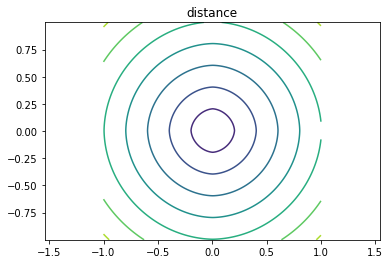

In [8]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

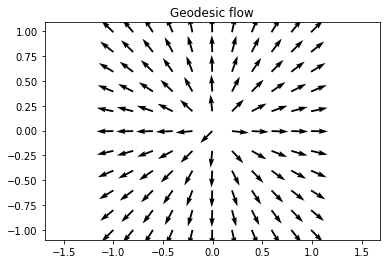

In [9]:
plt.title("Geodesic flow"); plt.axis('equal')
s=20; plt.quiver(*X[:,::s,::s],*gpuOut['flow'][:,::s,::s]);

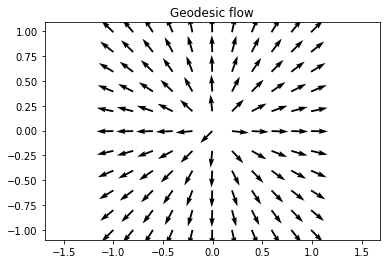

In [10]:
plt.title("Geodesic flow"); plt.axis('equal')
s=20; plt.quiver(*X[:,::s,::s],*gpuOut['flow'][:,::s,::s]);

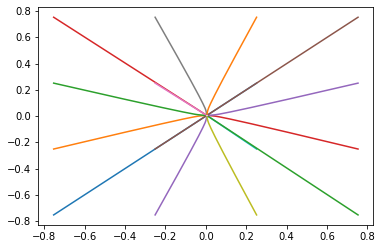

In [11]:
for geo in gpuOut['geodesics']: plt.plot(*geo);

### 1.2 Riemannian metrics

In [53]:
n=199
hfmIn = HFMUtils.dictIn({
    'model':'Riemann2',
    'seeds':[[0.,0.]],
    'exportValues':1,
    'metric':Metrics.Riemann(cp.array([[1.,1.],[1.,2.]])),
    'exportGeodesicFlow':1,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X = hfmIn.Grid()
hfmIn['tips']=hfmIn.Grid(dims=(4,4)).reshape(2,-1).T

Casting output of function array from float64 to float32


In [54]:
gpuOut = hfmIn.RunGPU()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.03747916221618652 seconds,  and 71 iterations.
Post-Processing


In [56]:
assert all(stop == 'AtSeed' for stop in gpuOut['geodesic_stopping_criteria'])
assert max([len(geo.T) for geo in gpuOut['geodesics']])<=450

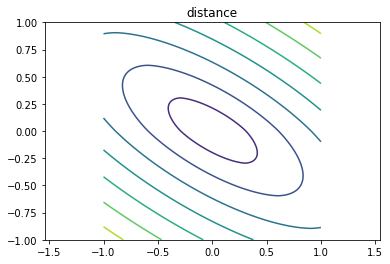

In [14]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

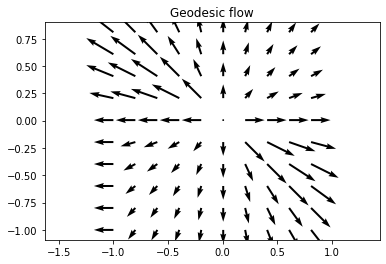

In [15]:
plt.title("Geodesic flow"); plt.axis('equal')
s=20; plt.quiver(*X[:,::s,::s],*gpuOut['flow'][:,::s,::s]);

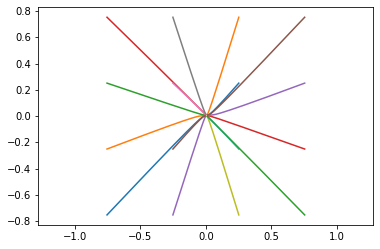

In [16]:
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);

### 1.3 Rander metrics

In [61]:
n=201
hfmIn = HFMUtils.dictIn({
    'model':'Rander2', 'metric':Metrics.Rander(cp.eye(2),cp.array([0.,0.5])),
    'seeds':[[0.,0.]],
    'exportValues':1,
    'exportGeodesicFlow':1,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X = hfmIn.Grid()
hfmIn['tips']=hfmIn.Grid(dims=(4,4)).reshape(2,-1).T

Casting output of function eye from float64 to float32
Casting output of function array from float64 to float32


In [62]:
gpuOut = hfmIn.RunGPU()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.016996383666992188 seconds,  and 28 iterations.
Post-Processing


In [64]:
assert all(stop == 'AtSeed' for stop in gpuOut['geodesic_stopping_criteria'])
assert max([len(geo.T) for geo in gpuOut['geodesics']])<=450

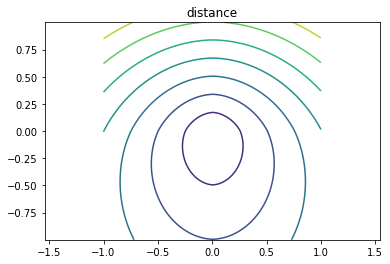

In [63]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

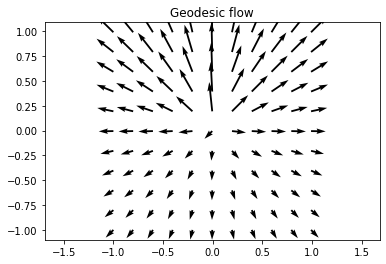

In [20]:
plt.title("Geodesic flow"); plt.axis('equal')
s=20; plt.quiver(*X[:,::s,::s],*gpuOut['flow'][:,::s,::s]);

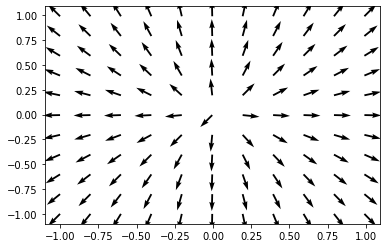

In [21]:
flow=gpuOut['flow'].copy(); flow/=ad.Optimization.norm(flow,axis=0) 
s=20; plt.quiver(*X[:,::s,::s],*flow[:,::s,::s]);

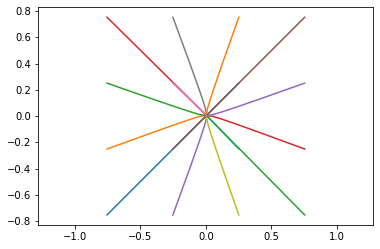

In [22]:
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);

## 2. Variable metrics

We reproduce a few classical test cases from the other notebooks.

### 2.1 Isotropic

In [66]:
n=200; 
hfmIn=HFMUtils.dictIn({
    'model':'Isotropic2',
    'exportValues':1,
    'seeds':[[0.,0.]],
    'verbosity':0,
    'exportGeodesicFlow':1,
    'geodesic_hlen':20,
    
    # Some hint is needed for Grid() to return the correct array type 
    'dummy_hint':cp.asarray(1.) # Add an arbitrary entry with the correct type
#    'array_float_caster':cp.asarray, # Alternatively, provide the array caster
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X = hfmIn.Grid()
hfmIn.update({
    'cost':np.prod(np.sin(2*np.pi*X),axis=0) +1.1, # Non-constant cost
    'tips':hfmIn.Grid(dims=(5,4)).reshape(2,-1).T
})

Casting output of function asarray from float64 to float32


In [67]:
gpuOut = hfmIn.RunGPU()

In [69]:
assert all(stop == 'AtSeed' for stop in gpuOut['geodesic_stopping_criteria'])
assert max([len(geo.T) for geo in gpuOut['geodesics']])<=600

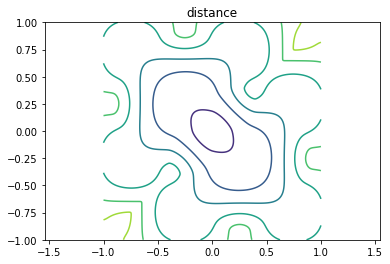

In [25]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

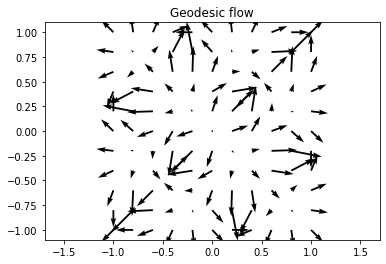

In [26]:
plt.title("Geodesic flow"); plt.axis('equal')
s=20; plt.quiver(*X[:,::s,::s],*gpuOut['flow'][:,::s,::s]);

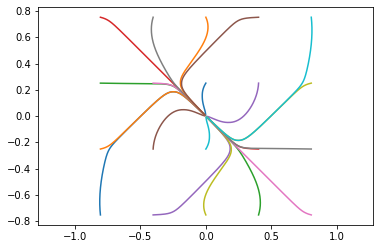

In [27]:
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);

### 2.2 Riemannian

In [74]:
hfmIn = HFMUtils.dictIn({
    'model':'Riemann2',
    'seeds':cp.array([[0.,0.]]),
    'exportValues':1,
    'exportGeodesicFlow':1,
    'multiprecision':True,
    'traits':{
        'niter_i':16,'shape_i':(8,8), # Best
    },
})
hfmIn.SetRect([[-np.pi,np.pi],[-np.pi,np.pi]],dimx=n+1,sampleBoundary=True)
X = hfmIn.Grid()

rot = fd.as_field(lp.rotation(cp.array(np.pi/6)),X.shape[1:])
def height(x): x=lp.dot_AV(rot,x); return np.sin(x[0])*np.sin(x[1])
def surface_metric(x,z,mu=10.):
    ndim,shape = x.ndim-1,x.shape[1:]
    x_ad = ad.Dense.identity(constant=x,shape_free=(ndim,))
    tensors = lp.outer_self( z(x_ad).gradient() ) + mu**-2 * fd.as_field(cp.eye(ndim),shape)
    return Metrics.Riemann(tensors)

hfmIn['metric'] = surface_metric(X,height,mu=10)
hfmIn['tips']=hfmIn.Grid(dims=(5,4)).reshape(2,-1).T

Casting output of function array from float64 to float32
Casting output of function array from float64 to float32
Casting output of function eye from float64 to float32


In [75]:
gpuOut = hfmIn.RunGPU()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.03949737548828125 seconds,  and 76 iterations.
Post-Processing


In [76]:
assert all(stop == 'AtSeed' for stop in gpuOut['geodesic_stopping_criteria'])
assert max([len(geo.T) for geo in gpuOut['geodesics']])<=550

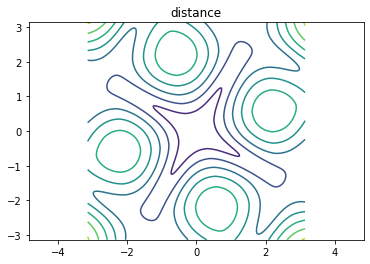

In [30]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

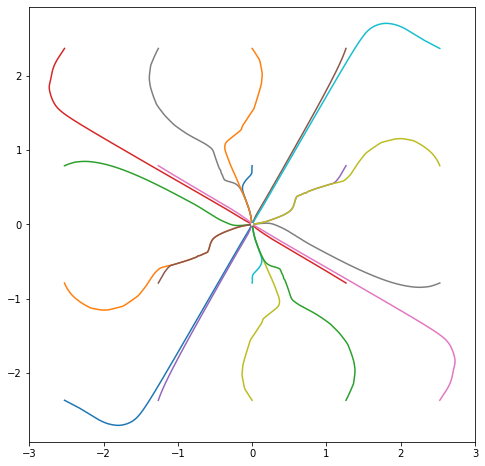

In [31]:
plt.figure(figsize=(8,8)); plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);

The geodesics display a rather surprising angle. However, it is reproduced by the cpu variant, with the ODE solver, and by the python streamplot command. (The cpu discrete geodesic solver does not show this behavior, but it possibly over-smoothes the result.)
<!---
, which is not visible in the cpu variant. However the values and flow coincide with good precision, and a streamplot reproduces the gpu geodesics behavior. This divergence may be explained by the already strong anisotropy, and rather wide stencils used.
--->
<!---
plt.figure(figsize=(16,16)); plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);
flow=cpuOut['flow']; flow = flow/ad.Optimization.norm(flow,axis=0)
s=2; plt.quiver(*X[:,::s,::s],*flow[:,::s,::s]);
--->

In [32]:
cpuIn = hfmIn.copy()
for key in ('array_float_caster','traits'): cpuIn.pop(key,None)
cpuIn['geodesicSolver']='ODE'
cpuOut = cpuIn.RunSmart()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.045 s.
Field geodesicStep defaults to 0.25
Field geodesicCausalityTolerance defaults to 4
Field geodesicTargetTolerance defaults to 6
***** Warning ! *****
Unused fields from user: multiprecision 
********************


In [33]:
cpuOut.keys()

dict_keys(['FMCPUTime', 'GeodesicCPUTime', 'MaxStencilWidth', 'StencilCPUTime', 'defaulted', 'flow', 'geodesics', 'nAccepted', 'unusedFromCompute', 'unusedFromUser', 'unusedHelp', 'values', 'visitedUnset', 'retcode'])

In [34]:
norm_infinity(cpuOut['values']-gpuOut['values'].get())

2.8222942138889096e-07

In [35]:
norm_infinity(cpuOut['flow']-gpuOut['flow'].get())

0.0002242020942795353

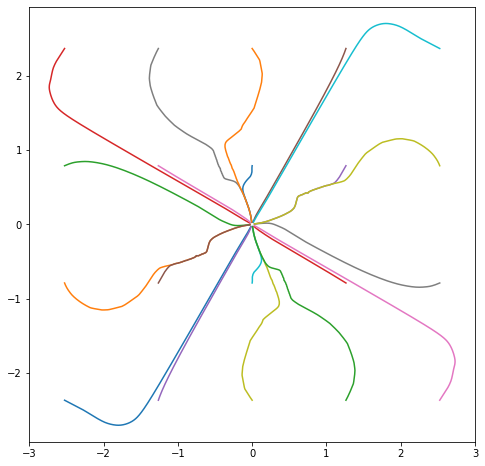

In [36]:
plt.figure(figsize=(8,8)); plt.axis('equal')
for geo in cpuOut['geodesics']: plt.plot(*geo);

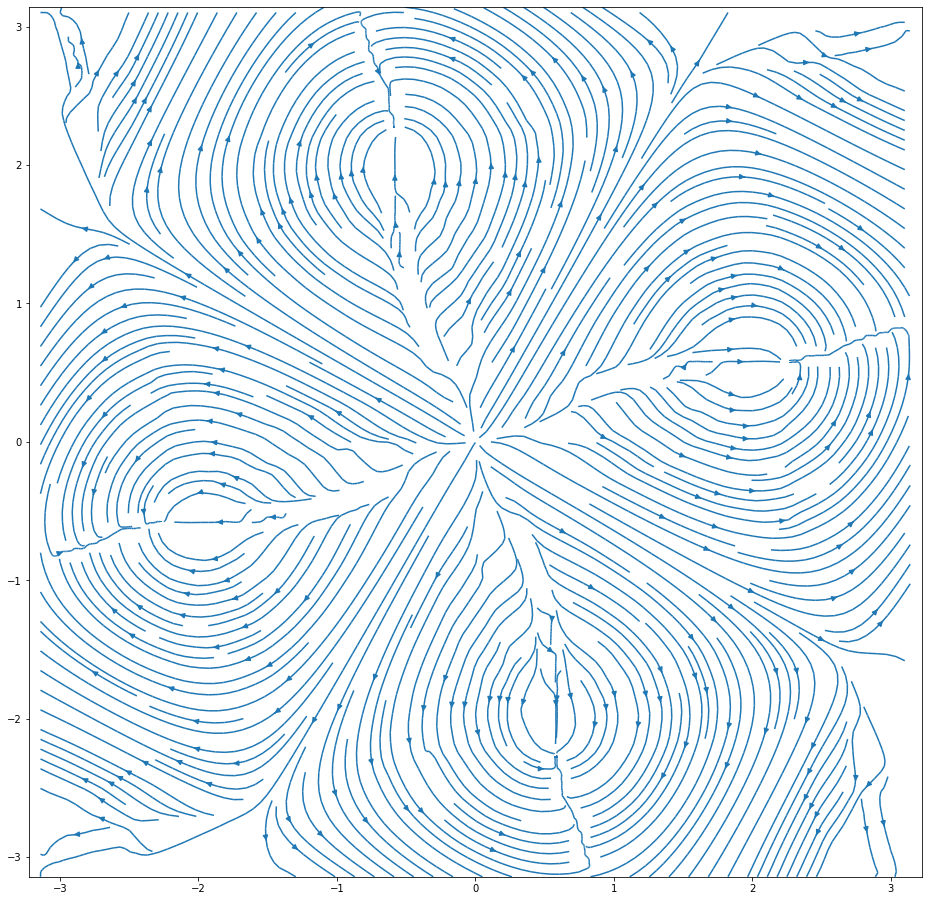

In [36]:
plt.figure(figsize=(16,16)); plt.axis('equal')
streamplot_ij(*X.get(),*cpuOut['flow'],density=3);

### 2.3 Rander

In [83]:
hfmIn = HFMUtils.dictIn({
    'model':'Rander2',
    'seeds':cp.array([[0.,0.]]),
    'exportValues':1,
})
hfmIn.SetRect([[-2.*np.pi,2.*np.pi],[-2.*np.pi,2.*np.pi]],dimx=n+1)
X = hfmIn.Grid()

def Drift(x):
    mult = 0.9*np.sin(x[0])*np.sin(x[1]) / np.linalg.norm(x,axis=0)
    mult[np.isnan(mult)]=0.
    return mult*x

hfmIn['metric']=Metrics.Rander.from_Zermelo(cp.eye(2),Drift(X))
hfmIn['tips']=hfmIn.Grid(dims=(5,4)).reshape(2,-1).T

Casting output of function array from float64 to float32
Casting output of function eye from float64 to float32


In [84]:
gpuOut = hfmIn.RunGPU()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.018999576568603516 seconds,  and 40 iterations.
Post-Processing


In [87]:
assert all(stop in ('AtSeed','VanishingFlow') for stop in gpuOut['geodesic_stopping_criteria'])
assert max([len(geo.T) for geo in gpuOut['geodesics']])<=600

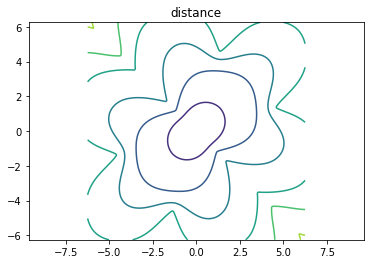

In [39]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

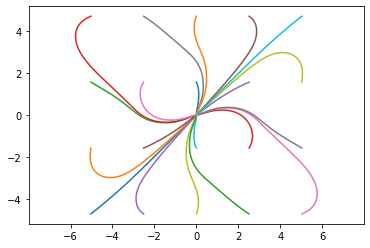

In [40]:
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);